In [20]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
df=pd.read_csv("test.csv")
df=df.dropna()
df.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.3+ KB


In [22]:
df.shape

(7600, 3)

**This file consists of 7600 testing samples of news articles that contain 3 columns. The first column is Class Id, the second column is Title and the third column is Description. The class ids are numbered 1-4 where 1 represents World, 2 represents Sports, 3 represents Business and 4 represents Sci/Tech.**
https://www.kaggle.com/code/omarmohamedhamed/news-classification/input

In [23]:
df['Class Index'].value_counts()

Class Index
3    1900
4    1900
2    1900
1    1900
Name: count, dtype: int64

In [24]:
df['text']=df['Title'].astype(str) +" "+df['Description'].astype(str)
df=df[['Class Index','text']]
df.head()

,Class Index,text
0,3,Fears for T N pension after talks Unions repre...
1,4,The Race is On: Second Private Team Sets Launc...
2,4,Ky. Company Wins Grant to Study Peptides (AP) ...
3,4,Prediction Unit Helps Forecast Wildfires (AP) ...
4,4,Calif. Aims to Limit Farm-Related Smog (AP) AP...


### **Code preprocesses text (lowercase, clean, remove stopwords) and adds it to a new column.**

In [25]:
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from sklearn.feature_extraction.text import TfidfVectorizer
stop_words=ENGLISH_STOP_WORDS
def prep(text):
    text=text.lower()
    text=re.sub(r'http\S+|www\S+','',text)
    text=re.sub(r'<.*?>','',text)
    text=re.sub(r'\d+','',text)
    text=text.translate(str.maketrans('','',string.punctuation))
    words=text_to_word_sequence(text)
    words=[w for w in words if w not in stop_words]
    return " ".join(words)
df['prep_text']=df['text'].apply(prep)
df.head()

,Class Index,text,prep_text
0,3,Fears for T N pension after talks Unions repre...,fears t n pension talks unions representing wo...
1,4,The Race is On: Second Private Team Sets Launc...,race second private team sets launch date huma...
2,4,Ky. Company Wins Grant to Study Peptides (AP) ...,ky company wins grant study peptides ap ap com...
3,4,Prediction Unit Helps Forecast Wildfires (AP) ...,prediction unit helps forecast wildfires ap ap...
4,4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,calif aims limit farmrelated smog ap ap southe...


### **The code encodes labels, splits the data into train/test sets using stratification, and applies TF-IDF vectorization with unigrams and bigrams.**

In [26]:
le=LabelEncoder()
df['label']=le.fit_transform(df['Class Index'])
df[['Class Index','label']].head()
X=df['prep_text']
y=df['label']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=11,stratify=y)
tfidf=TfidfVectorizer(max_features=25000,ngram_range=(1,2))
X_train_tfidf=tfidf.fit_transform(X_train)
X_test_tfidf=tfidf.transform(X_test)

### **The code trains a LinearSVC model on TF-IDF features and prints its accuracy and classification report.**

In [27]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
svm=LinearSVC()
svm.fit(X_train_tfidf,y_train)
y_pred_svm=svm.predict(X_test_tfidf)
print("SVM accuracy:",accuracy_score(y_test,y_pred_svm))
print("\nSVM Report:\n")
print(classification_report(y_test,y_pred_svm))

SVM accuracy: 0.8836842105263157

SVM Report:

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       475
           1       0.92      0.97      0.95       475
           2       0.85      0.84      0.85       475
           3       0.84      0.85      0.85       475

    accuracy                           0.88      1900
   macro avg       0.88      0.88      0.88      1900
weighted avg       0.88      0.88      0.88      1900



### Multinomial Naive Bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()
nb.fit(X_train_tfidf,y_train)
y_pred_nb=nb.predict(X_test_tfidf)
print("Naive Bayes accuracy:",accuracy_score(y_test,y_pred_nb))
print(classification_report(y_test,y_pred_nb))

Naive Bayes accuracy: 0.8894736842105263
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       475
           1       0.93      0.97      0.95       475
           2       0.85      0.85      0.85       475
           3       0.86      0.84      0.85       475

    accuracy                           0.89      1900
   macro avg       0.89      0.89      0.89      1900
weighted avg       0.89      0.89      0.89      1900



### Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=200,random_state=11)
rf.fit(X_train_tfidf,y_train)
y_pred_rf=rf.predict(X_test_tfidf)
print("Random Forest accuracy:",accuracy_score(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))

Random Forest accuracy: 0.8415789473684211
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       475
           1       0.90      0.92      0.91       475
           2       0.83      0.79      0.81       475
           3       0.76      0.83      0.79       475

    accuracy                           0.84      1900
   macro avg       0.84      0.84      0.84      1900
weighted avg       0.84      0.84      0.84      1900



### Checking model predictions (0-world, 1-sport, 2-business, 3-Sci/Tech)

In [30]:
#This code iterates through test news texts, converts each one using TF-IDF, predicts its category with the SVM model, and prints the result.
test_text=[
    ["Serena Williams announces retirement after US Open final victory ceremony."],
    ["Diplomatic talks resume between North and South Korea at border village."],
    ["NBA playoffs: Golden State Warriors advance to finals after game seven win."],
    ["Tesla announces new factory in Texas creating over 10,000 manufacturing jobs."],
    ["New smartphone features foldable screen and advanced camera AI technology."],
    ["Bitcoin price volatility continues as cryptocurrency regulations tighten globally."]
]
for i,test in enumerate(test_text):
    X_test=tfidf.transform(test)
    test_label=svm.predict(X_test)[0]
    print(f"Model {i+1}")
    print("Text:",test_text[i])
    print(f"Predicted news type:{test_label}\n")

Model 1
Text: ['Serena Williams announces retirement after US Open final victory ceremony.']
Predicted news type:1

Model 2
Text: ['Diplomatic talks resume between North and South Korea at border village.']
Predicted news type:0

Model 3
Text: ['NBA playoffs: Golden State Warriors advance to finals after game seven win.']
Predicted news type:1

Model 4
Text: ['Tesla announces new factory in Texas creating over 10,000 manufacturing jobs.']
Predicted news type:2

Model 5
Text: ['New smartphone features foldable screen and advanced camera AI technology.']
Predicted news type:3

Model 6
Text: ['Bitcoin price volatility continues as cryptocurrency regulations tighten globally.']
Predicted news type:2



In [31]:
# This code iterates through test news texts, converts each one using TF-IDF, predicts its category with the Random Forest model, and prints the result.
test_text=[
    ["Serena Williams announces retirement after US Open final victory ceremony."],
    ["Diplomatic talks resume between North and South Korea at border village."],
    ["NBA playoffs: Golden State Warriors advance to finals after game seven win."],
    ["Tesla announces new factory in Texas creating over 10,000 manufacturing jobs."],
    ["New smartphone features foldable screen and advanced camera AI technology."],
    ["Bitcoin price volatility continues as cryptocurrency regulations tighten globally."]
]
for i,test in enumerate(test_text):
    X_test=tfidf.transform(test)
    test_label=rf.predict(X_test)[0]
    print(f"Model {i+1}")
    print("Text:",test_text[i])
    print(f"Predicted news type:{test_label}\n")

Model 1
Text: ['Serena Williams announces retirement after US Open final victory ceremony.']
Predicted news type:1

Model 2
Text: ['Diplomatic talks resume between North and South Korea at border village.']
Predicted news type:0

Model 3
Text: ['NBA playoffs: Golden State Warriors advance to finals after game seven win.']
Predicted news type:1

Model 4
Text: ['Tesla announces new factory in Texas creating over 10,000 manufacturing jobs.']
Predicted news type:3

Model 5
Text: ['New smartphone features foldable screen and advanced camera AI technology.']
Predicted news type:3

Model 6
Text: ['Bitcoin price volatility continues as cryptocurrency regulations tighten globally.']
Predicted news type:3



In [32]:
#This code iterates through test news texts, converts each one using TF-IDF, predicts its category with the Naive Bayes model, and prints the result.
test_text=[
    ["Serena Williams announces retirement after US Open final victory ceremony."],
    ["Diplomatic talks resume between North and South Korea at border village."],
    ["NBA playoffs: Golden State Warriors advance to finals after game seven win."],
    ["Tesla announces new factory in Texas creating over 10,000 manufacturing jobs."],
    ["New smartphone features foldable screen and advanced camera AI technology."],
    ["Bitcoin price volatility continues as cryptocurrency regulations tighten globally."]
]
for i,test in enumerate(test_text):
    X_test=tfidf.transform(test)
    test_label=nb.predict(X_test)[0]
    print(f"Model {i+1}")
    print("Text:",test_text[i])
    print(f"Predicted news type:{test_label}\n")

Model 1
Text: ['Serena Williams announces retirement after US Open final victory ceremony.']
Predicted news type:1

Model 2
Text: ['Diplomatic talks resume between North and South Korea at border village.']
Predicted news type:0

Model 3
Text: ['NBA playoffs: Golden State Warriors advance to finals after game seven win.']
Predicted news type:1

Model 4
Text: ['Tesla announces new factory in Texas creating over 10,000 manufacturing jobs.']
Predicted news type:2

Model 5
Text: ['New smartphone features foldable screen and advanced camera AI technology.']
Predicted news type:3

Model 6
Text: ['Bitcoin price volatility continues as cryptocurrency regulations tighten globally.']
Predicted news type:2



### Confusion matrix for models

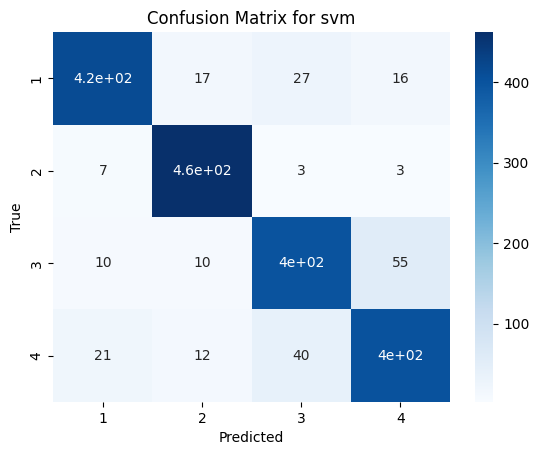

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
cm=confusion_matrix(y_test,y_pred_svm)
sns.heatmap(cm,annot=True,xticklabels=le.classes_,yticklabels=le.classes_,cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for svm")
plt.show()

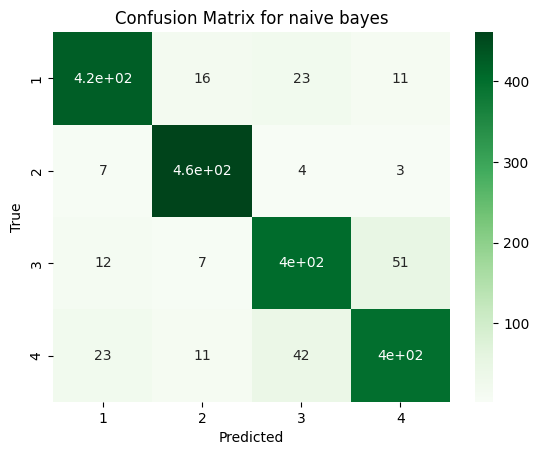

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
cm=confusion_matrix(y_test,y_pred_nb)
sns.heatmap(cm,annot=True,xticklabels=le.classes_,yticklabels=le.classes_,cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for naive bayes")
plt.show()

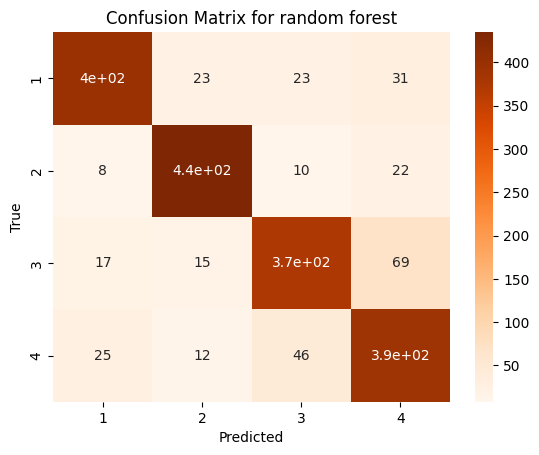

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
cm=confusion_matrix(y_test,y_pred_rf)
sns.heatmap(cm,annot=True,xticklabels=le.classes_,yticklabels=le.classes_,cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for random forest")
plt.show()

In [38]:
import joblib

joblib.dump(tfidf,'models/tfidf_vectorizer.pkl')
joblib.dump(svm,'models/svm_model.pkl')
joblib.dump(nb,'models/naive_bayes_model.pkl')
joblib.dump(rf,'models/random_forest_model.pkl')
joblib.dump(le,'models/label_encoder.pkl')

['models/label_encoder.pkl']